# Imports

In [1]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from pycoingecko import CoinGeckoAPI
from sklearn.model_selection import train_test_split
import requests
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import plotly.express as px

# Import data

In [2]:


def get_crypto_price(symbol, exchange, start_date = None):
    api_key = 'YOUR API KEY'
    api_url = f'https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={symbol}&market={exchange}&apikey={api_key}'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df['Time Series (Digital Currency Daily)']).T
    df = df.rename(columns = {'1a. open (USD)': 'open', '2a. high (USD)': 'high', '3a. low (USD)': 'low', '4a. close (USD)': 'close', '5. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['1b. open (USD)', '2b. high (USD)', '3b. low (USD)', '4b. close (USD)', '6. market cap (USD)'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

df = get_crypto_price(symbol = 'ADA', exchange = 'USD', start_date = '2020-01-01')
df

,open,high,low,close,volume
2020-01-01,0.03285,0.03380,0.03270,0.03348,29827408.5
2020-01-02,0.03345,0.03348,0.03218,0.03269,42826456.1
2020-01-03,0.03269,0.03446,0.03236,0.03417,102581046.7
2020-01-04,0.03417,0.03450,0.03375,0.03434,55528746.4
2020-01-05,0.03436,0.03527,0.03419,0.03460,71815282.1
...,...,...,...,...,...
2022-02-03,1.02700,1.06200,1.01600,1.06100,98542208.5
2022-02-04,1.06100,1.13900,1.04500,1.13800,135205051.6
2022-02-05,1.13800,1.17800,1.09700,1.12500,152710784.3
2022-02-06,1.12500,1.15000,1.09700,1.14300,107099317.0


## Plot prices

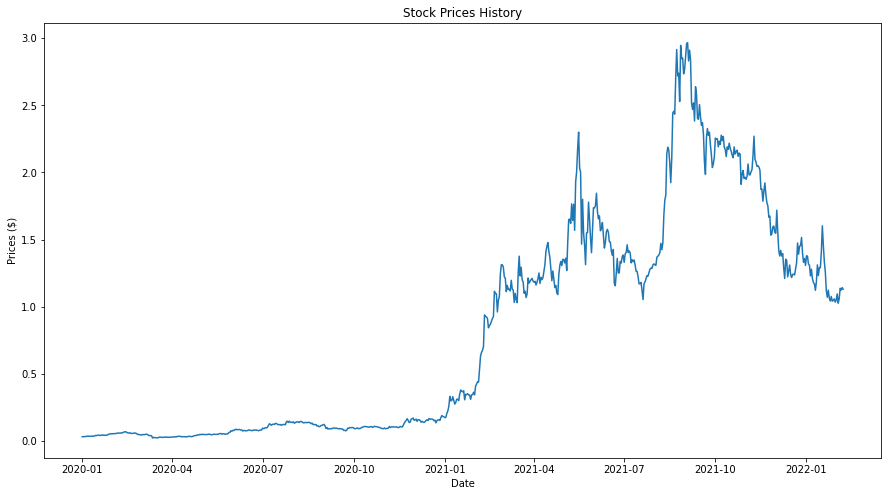

In [3]:
plt.figure(figsize=(15, 8))
plt.title('Stock Prices History')
plt.plot(df['close'])
plt.xlabel('Date')
plt.ylabel('Prices ($)');

In [4]:
fig = go.Figure(data=[go.Candlestick(x=df.index,
                open=df['open'],
                high=df['high'],
                low=df['low'],
                close=df['close'])])

fig.show()

## Normalise data and split intro train and test datasets

In [5]:
# retrieve close and open values
close = df['close'].values
open = df['open'].values

# normalise data to 0-1 and transform it
scaler = MinMaxScaler()

X = scaler.fit_transform(close.reshape(-1,1))
y = scaler.fit_transform(open.reshape(-1,1))

# split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)


# Build LSTM model

In [6]:
'''
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
#model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(50))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()
'''

'\nmodel = keras.Sequential()\nmodel.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))\n#model.add(layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))\nmodel.add(layers.LSTM(100, return_sequences=False))\nmodel.add(layers.Dense(50))\nmodel.add(layers.Dense(25))\nmodel.add(layers.Dense(1))\nmodel.summary()\n'

In [7]:
from keras.layers import *

model = keras.Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.5))
# Adding a second LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
model.add(LSTM(units = 50))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 100)            40800     
                                                                 
 dropout (Dropout)           (None, 1, 100)            0         
                                                                 
 lstm_1 (LSTM)               (None, 1, 50)             30200     
                                                                 
 dropout_1 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 1, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 1, 50)             0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

# Train process

In [8]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 32, epochs=10)

Epoch 1/10
20/20 [==============================] - 9s 7ms/step - loss: 0.1315
Epoch 2/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0851
Epoch 3/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0548
Epoch 4/10
20/20 [==============================] - 0s 9ms/step - loss: 0.0291
Epoch 5/10
20/20 [==============================] - 0s 10ms/step - loss: 0.0092
Epoch 6/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0071
Epoch 7/10
20/20 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 8/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 9/10
20/20 [==============================] - 0s 8ms/step - loss: 0.0048
Epoch 10/10
20/20 [==============================] - 0s 13ms/step - loss: 0.0049


# Test process

In [9]:
# obtain model predictions which are in the range 0-1
predictions = model.predict(X_test)

y_true = y_test
y_pred = predictions

# evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r_squared = r2_score(y_true, y_pred)

print(mse, rmse, r_squared)

0.0009956862591983453 0.03155449665575962 0.9867380343261727


In [10]:
#compare = pd.DataFrame[{'actual':y_test, 'preds':y_pred}]
compare = pd.DataFrame(zip([i[0] for i in y_pred], [i[0] for i in y_true]),
               columns =['Predicted', 'Actual'])

In [11]:

fig = px.line(
    compare,
    x=compare.index,
    y=['Predicted', 'Actual'],
    title='Actual vs Predicted Opening Value', markers='True'
)

fig.show()

# Predict January 2022

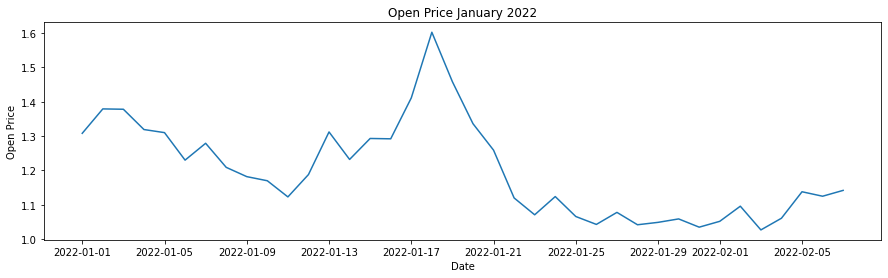

In [12]:
jan = df.reset_index().rename(columns={'index':'Date'})
jan['Date'] = pd.to_datetime(jan['Date'])
test_data = jan[(jan.Date.dt.year==2022) & (jan.Date.dt.month==1)]

# plot january 2022 data
plt.figure(figsize=(15,4))
plt.title('Open Price January 2022')
plt.ylabel('Open Price')
plt.xlabel('Date')
plt.plot(jan[jan['Date'].dt.year==2022].Date,jan[jan['Date'].dt.year==2022].open);


In [13]:
# close and open values for jan 2022
X_test_jan = scaler.fit_transform(test_data.close.values.reshape(-1,1))
y_test_jan = scaler.fit_transform(test_data.open.values.reshape(-1,1))

# predict the open values 
jan_preds = model.predict(X_test_jan)
jan_preds = scaler.inverse_transform(jan_preds)
y_true = scaler.inverse_transform(y_test_jan)

#y_true = y_test_jan

# evaluation metrics
mse = mean_squared_error(y_true, jan_preds)
rmse = np.sqrt(mse)
r_squared = r2_score(y_true, jan_preds)

print(mse, rmse, r_squared)

0.006290147489889432 0.07931045006737406 0.6772722010721298


In [14]:
compare = pd.DataFrame(zip([i[0] for i in jan_preds], [i[0] for i in y_true]),
               columns =['Predicted', 'Actual'])


fig = px.line(
    compare,
    x=compare.index,
    y=['Predicted', 'Actual'],
    title='Actual vs Predicted Opening Value for January 2022', markers='True'
)

fig.show()